<a href="https://colab.research.google.com/github/WIVIV/Project_3_AFI/blob/master/Copy_of_Proj_3_WF_GRID_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml h5py 

**Use TensorFlow V2.x**

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
!rm -rf ./logs/ 

TensorFlow 2.x selected.


Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.models import Sequential

from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

Test GPU available

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Import images from DropBox

In [5]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"


--2020-02-14 16:52:12--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2020-02-14 16:52:12--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucca2f2247990259371aea5a7e24.dl.dropboxusercontent.com/cd/0/inline/AyF3lVg6qzjLKjMiCouws_sk7qXuGjPU28EAgJMRc4W1d3tZ_7fyHAzalr5b9KI9wguUEso8UgDmGtXC_MQSvm0kIkCJziRHpr_04Qe2jB4YoxZebFyROdsGLwDENYAbvpA/file# [following]
--2020-02-14 16:52:12--  https://ucca2f2247990259371aea5a7e24.dl.dropboxusercontent.com/cd/0/inline/AyF3lVg6qzjLKjMiCouws_sk7qXuGjPU28EAgJMRc4W1d3tZ_7fyHAzalr5b9KI9wguUEso8UgDmGtXC_MQSvm0kIkCJziRHpr_04Q

Inspect Image Archive File

In [6]:
!tar -xvf 'grid_version.tar'

Streaming output truncated to the last 5000 lines.
grid_version/train/grid_no_smoke/1498418433_+02040_06_05.png
grid_version/train/grid_no_smoke/1498418373_+01980_08_09.png
grid_version/train/grid_no_smoke/1498418493_+02100_05_06.png
grid_version/train/grid_no_smoke/1498417893_+01500_02_06.png
grid_version/train/grid_no_smoke/1498418253_+01860_04_07.png
grid_version/train/grid_no_smoke/1498418013_+01620_09_06.png
grid_version/train/grid_no_smoke/1498416993_+00600_04_08.png
grid_version/train/grid_no_smoke/1498416993_+00600_03_01.png
grid_version/train/grid_no_smoke/1498417233_+00840_02_01.png
grid_version/train/grid_no_smoke/1498416693_+00300_08_07.png
grid_version/train/grid_no_smoke/1498416693_+00300_06_02.png
grid_version/train/grid_no_smoke/1498418013_+01620_07_03.png
grid_version/train/grid_no_smoke/1498418373_+01980_01_05.png
grid_version/train/grid_no_smoke/1498417533_+01140_03_05.png
grid_version/train/grid_no_smoke/1498416753_+00360_03_04.png
grid_version/train/grid_no_smoke/1

Split data into train and vaildate

In [0]:
train_image_folder ='grid_version/train'
validate_image_folder = 'grid_version/validate'

In [0]:
train_smoke_dir = 'grid_version/train/grid_smoke'  # directory with our training smoke pictures
train_nosmoke_dir = 'grid_version/train/grid_no_smoke'  # directory with our training no smoke pictures
validation_smoke_dir = 'grid_version/validate/grid_smoke' # directory with our validation smoke pictures
validation_nosmoke_dir = 'grid_version/validate/grid_no_smoke' # directory with our validation no smoke pictures


In [0]:
num_smoke_tr = len(os.listdir(train_smoke_dir))
num_nosmoke_tr = len(os.listdir(train_nosmoke_dir))

num_smoke_val = len(os.listdir(validation_smoke_dir))
num_nosmoke_val = len(os.listdir(validation_nosmoke_dir))

total_train = num_smoke_tr + num_nosmoke_tr
total_val = num_smoke_val + num_nosmoke_val

In [10]:
print('total training smoke images:', num_smoke_tr)
print('total training nosmoke images:', num_nosmoke_tr)

print('total validation smoke images:', num_smoke_val)
print('total validation nosomke images:', num_nosmoke_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Distribution = {
'Total training images': total_train,
'Total validation images': total_val,
'total training smoke images': num_smoke_tr,
'total training nosmoke images': num_nosmoke_tr,
'total validation smoke images': num_smoke_val,
'total validation nosomke images': num_nosmoke_val
}

total training smoke images: 999
total training nosmoke images: 2622
total validation smoke images: 999
total validation nosomke images: 2622
--
Total training images: 3621
Total validation images: 3621


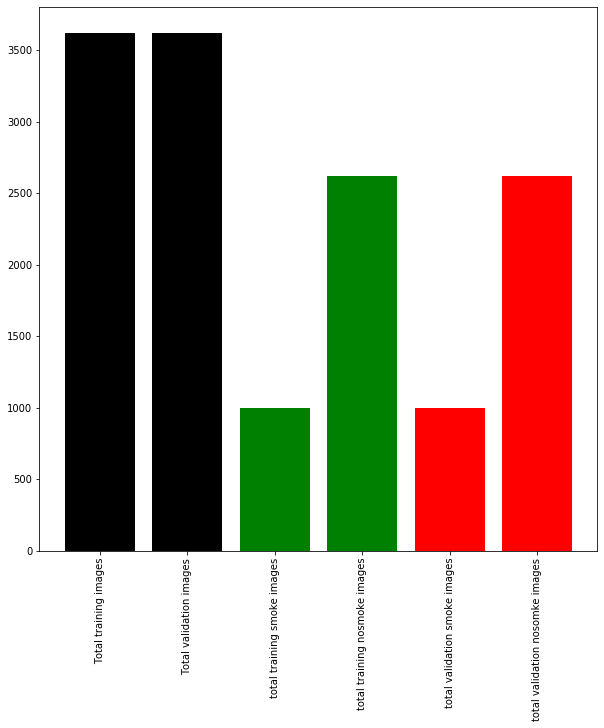

In [11]:
plt.figure(figsize=(10, 10))
plt.bar(range(len(Distribution)), list(Distribution.values()), align='center',color=['black', 'black', 'green', 'green', 'red','red'])
plt.xticks(range(len(Distribution)), list(Distribution.keys()),rotation=90)
plt.show()

**Create data generator**

In [0]:
#augment the images. Note best results were gained with limited preprocessing
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            ##Have tried different combintions and values of these settings
                                            #rotation_range=40,
                                            #width_shift_range=0.2,
                                            #height_shift_range=0.2,
                                            #brightness_range=[0.3,-2],
                                            #shear_range=0.2,
                                            #zoom_range=0.2,
                                            #horizontal_flip=True,
                                            #fill_mode='nearest')
)
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Set Paramaters

In [0]:
batch_size = 30
IMG_HEIGHT = 224
IMG_WIDTH = 224
class_mode='binary'


Create train and validate data generators

In [14]:
train_data_gen = train_image_generator.flow_from_directory(train_image_folder,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=class_mode)

Found 3621 images belonging to 2 classes.


In [15]:
val_data_gen = validation_image_generator.flow_from_directory(validate_image_folder,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=class_mode)

Found 3621 images belonging to 2 classes.


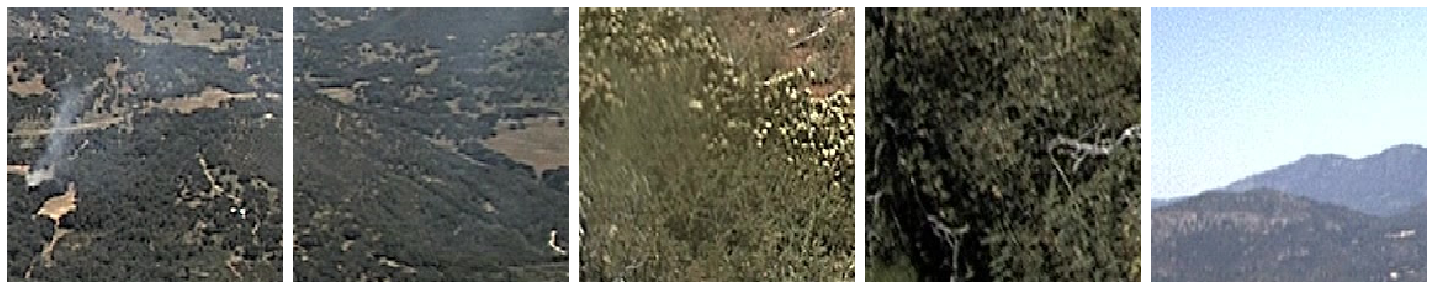

In [16]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  
plotImages(sample_training_images[:5])

Create Custom Built Model

In [17]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


from tensorflow.keras.optimizers import RMSprop, Adam
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

Create logs for TensorBoard

In [0]:
logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [19]:
initial_epochs = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=initial_epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    verbose=1,
    callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 1/15
120/120 [==============================] - 29s 242ms/step - loss: 0.6190 - accuracy: 0.8118 - val_loss: 0.2220 - val_accuracy: 0.9203
Epoch 2/15
120/120 [==============================] - 21s 179ms/step - loss: 0.2405 - accuracy: 0.9145 - val_loss: 0.1393 - val_accuracy: 0.9519
Epoch 3/15
120/120 [==============================] - 22s 180ms/step - loss: 0.1488 - accuracy: 0.9515 - val_loss: 0.0663 - val_accuracy: 0.9811
Epoch 4/15
120/120 [==============================] - 22s 182ms/step - loss: 0.1362 - accuracy: 0.9577 - val_loss: 0.0664 - val_accuracy: 0.9792
Epoch 5/15
120/120 [==============================] - 21s 178ms/step - loss: 0.0964 - accuracy: 0.9652 - val_loss: 0.0735 - val_accuracy: 0.9786
Epoch 6/15
120/120 [==============================] - 21s 176ms/step - loss: 0.0780 - accuracy: 0.9749 - val_loss: 0.2332 - val_accuracy: 0.9367
Epoch 7/15
120/120 [================

Plot results

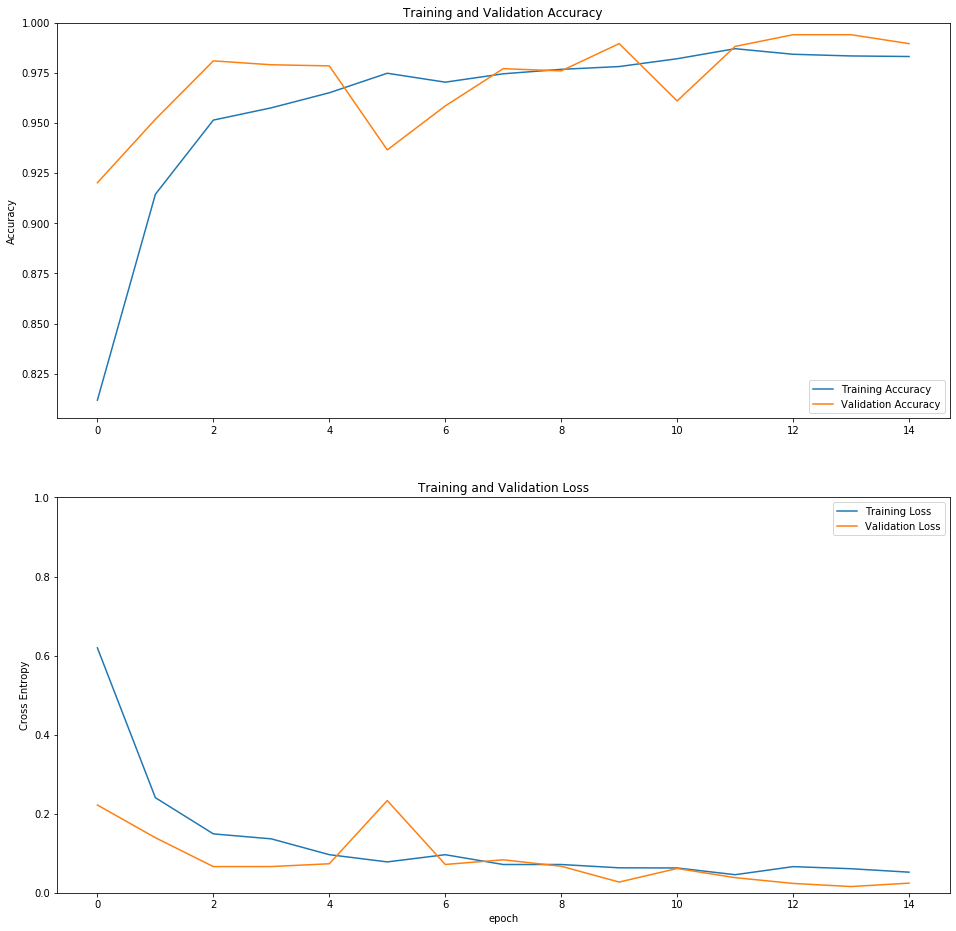

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Transfer Learning**

In [21]:
#Tranfser Learning using models that are composed of two parts:Convolutional base & Classifier.

from keras.applications import VGG19

#create a base model
base_model = tf.keras.applications.VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH,3), include_top=False,weights='imagenet')#image net weights removed

Using TensorFlow backend.


80142336/80134624 [==============================] - 2s 0us/step


In [22]:
batch_size=40

class_mode = 'binary'
total_classes = 1
activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'


#total_classes = 2
#activation_function = 'sigmoid'
#loss_function = 'binary_crossentropy'


train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0,
            #shear_range=0.2, 
            #zoom_range=[0.9, 1.25],
            #brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            vertical_flip=True
            )
     

validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0)


train_generator = train_image_generator.flow_from_directory(
            train_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)

validation_generator = validation_image_generator.flow_from_directory(
            validate_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)




Found 3621 images belonging to 2 classes.
Found 3621 images belonging to 2 classes.


In [23]:
reload_checkpoint=True
img_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(total_classes, activation=activation_function)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = False

model.compile(optimizer=RMSprop(lr=0.001),
              loss=loss_function,
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [24]:
tl_epochs = 10
stage_2_epochs = initial_epochs + tl_epochs
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


history_tl = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=stage_2_epochs,
      initial_epoch=history.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 90 steps, validate for 90 steps
Epoch 15/25
90/90 [==============================] - 57s 628ms/step - loss: 0.5405 - accuracy: 0.7244 - val_loss: 0.5008 - val_accuracy: 0.7233
Epoch 16/25
90/90 [==============================] - 54s 601ms/step - loss: 0.4743 - accuracy: 0.7275 - val_loss: 0.4525 - val_accuracy: 0.7336
Epoch 17/25
90/90 [==============================] - 54s 605ms/step - loss: 0.4333 - accuracy: 0.7612 - val_loss: 0.4171 - val_accuracy: 0.8150
Epoch 18/25
90/90 [==============================] - 54s 605ms/step - loss: 0.3984 - accuracy: 0.8204 - val_loss: 0.3882 - val_accuracy: 0.8436
Epoch 19/25
90/90 [==============================] - 55s 607ms/step - loss: 0.3728 - accuracy: 0.8595 - val_loss: 0.3651 - val_accuracy: 0.8669
Epoch 20/25
90/90 [==============================] - 55s 606ms/step - loss: 0.3520 - accuracy: 0.8676 - val_loss: 0.3451 - val_accuracy: 0.8756
Epoch 21/25
90/90 [=========================

In [0]:
acc += history_tl.history['accuracy']
val_acc += history_tl.history['val_accuracy']

loss += history_tl.history['loss']
val_loss += history_tl.history['val_loss']

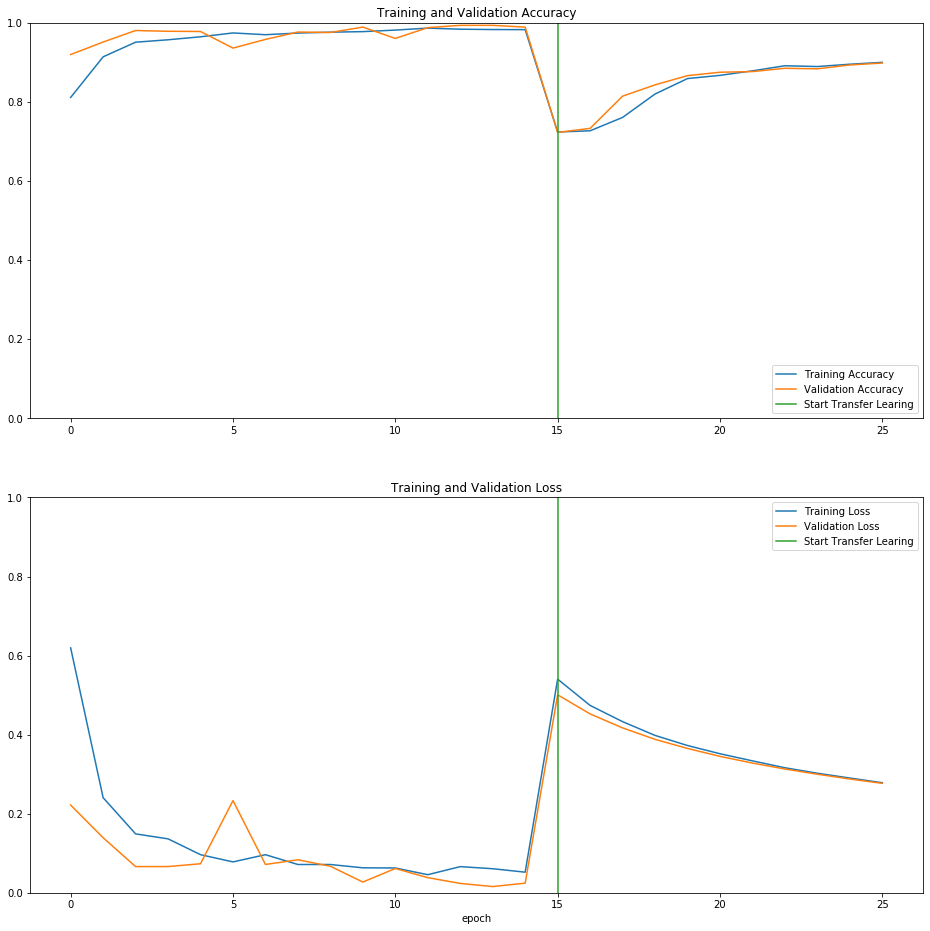

In [26]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


**Fine Tuning**

In [27]:
#Fine-tune a subset of top layers
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune start from layer 10
fine_tune_at = 19

# Freeze layers before fine tuning layer
for layer in base_model.layers[:fine_tune_at]:
     layer.trainable = False

model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 4,720,129
Non-trainable params: 15,304,768
_________________________________________________________________


In [28]:
fine_tune_epochs = 10
stage_3_epochs = stage_2_epochs + fine_tune_epochs

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history_fine = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=stage_3_epochs,
      initial_epoch=history_tl.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 90 steps, validate for 90 steps
Epoch 25/35
90/90 [==============================] - 57s 634ms/step - loss: 0.4103 - accuracy: 0.8699 - val_loss: 0.1244 - val_accuracy: 0.9633
Epoch 26/35
90/90 [==============================] - 56s 623ms/step - loss: 0.0883 - accuracy: 0.9743 - val_loss: 0.0736 - val_accuracy: 0.9819
Epoch 27/35
90/90 [==============================] - 56s 625ms/step - loss: 0.0820 - accuracy: 0.9749 - val_loss: 0.0600 - val_accuracy: 0.9806
Epoch 28/35
90/90 [==============================] - 56s 626ms/step - loss: 0.0643 - accuracy: 0.9802 - val_loss: 0.0577 - val_accuracy: 0.9797
Epoch 29/35
90/90 [==============================] - 56s 624ms/step - loss: 0.0698 - accuracy: 0.9793 - val_loss: 0.0515 - val_accuracy: 0.9814
Epoch 30/35
90/90 [==============================] - 56s 626ms/step - loss: 0.0602 - accuracy: 0.9816 - val_loss: 0.0501 - val_accuracy: 0.9836
Epoch 31/35
90/90 [=========================

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

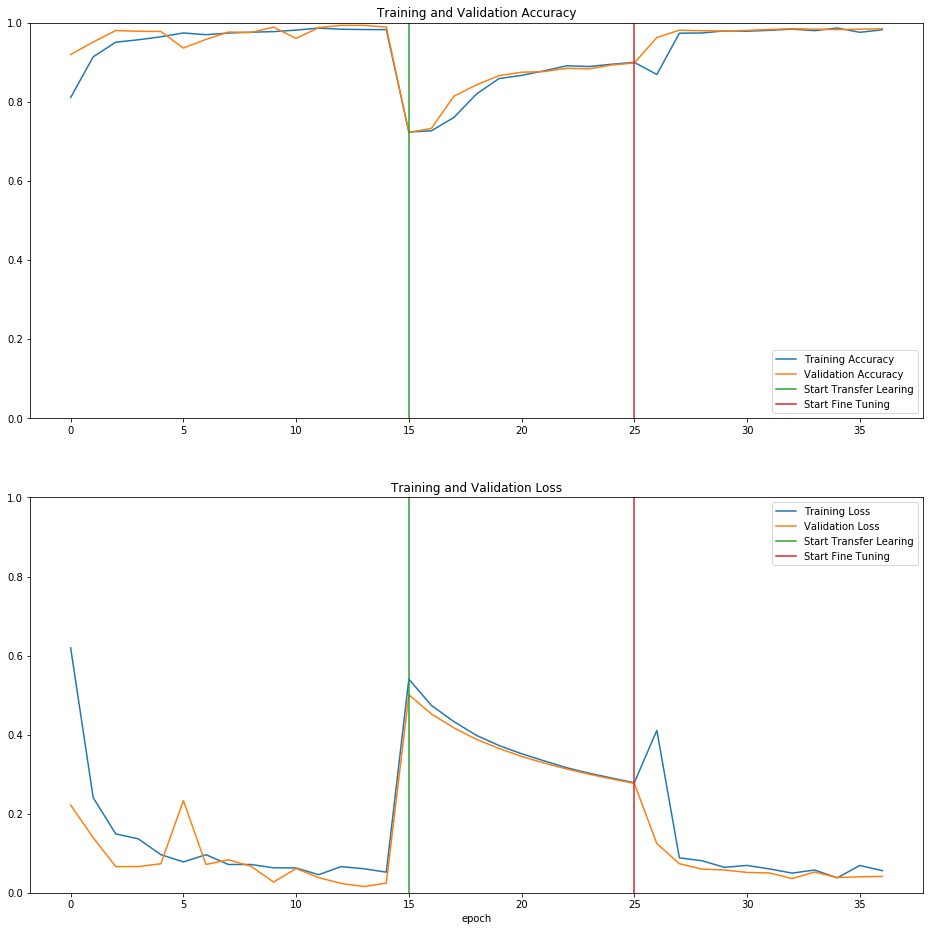

In [31]:
plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Transfer Learing')
plt.plot([stage_2_epochs,stage_2_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), label='Start Transfer Learing')
plt.plot([stage_2_epochs,stage_2_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

BREAK